##***DocAssist (Building Intelligent Medical Decision Support System) ***

##Problem Statement

The objective of this project is to develop an intelligent medical decision support system that analyzes patient data to assist doctors in making informed decisions about the best treatment options for individual patients. By leveraging machine learning and data analysis, the system will provide personalized treatment recommendations based on the patient's medical history, symptoms, lab results, and other relevant factors.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

import warnings
warnings.filterwarnings('ignore')

##***load dataset***

In [5]:
data=pd.read_csv("/content/dataset(in).csv")
data

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,F,1
1,44.6,14.0,6.86,6.3,232,20.4,31.4,65.0,36,M,0
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,F,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,F,0
4,40.6,13.3,4.85,14.9,711,27.4,32.8,83.7,36,M,0
...,...,...,...,...,...,...,...,...,...,...,...
3304,39.0,13.2,4.45,4.0,50,29.7,33.8,87.6,45,M,1
3305,25.4,8.2,3.27,5.4,90,25.1,32.3,77.7,1,F,1
3306,38.2,12.4,4.40,8.4,328,28.2,32.5,86.8,64,M,0
3307,43.4,15.2,5.29,10.1,326,28.7,35.0,82.0,33,M,0


##***EDA - Exploratory Data Analysis***

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   3309 non-null   float64
 1   HAEMOGLOBINS  3309 non-null   float64
 2   ERYTHROCYTE   3309 non-null   float64
 3   LEUCOCYTE     3309 non-null   float64
 4   THROMBOCYTE   3309 non-null   int64  
 5   MCH           3309 non-null   float64
 6   MCHC          3309 non-null   float64
 7   MCV           3309 non-null   float64
 8   AGE           3309 non-null   int64  
 9   SEX           3309 non-null   object 
 10  SOURCE        3309 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 284.5+ KB


In [10]:
#find the data duplicate
data.duplicated().sum()

0

##VISUALIZE THE RAW DATA

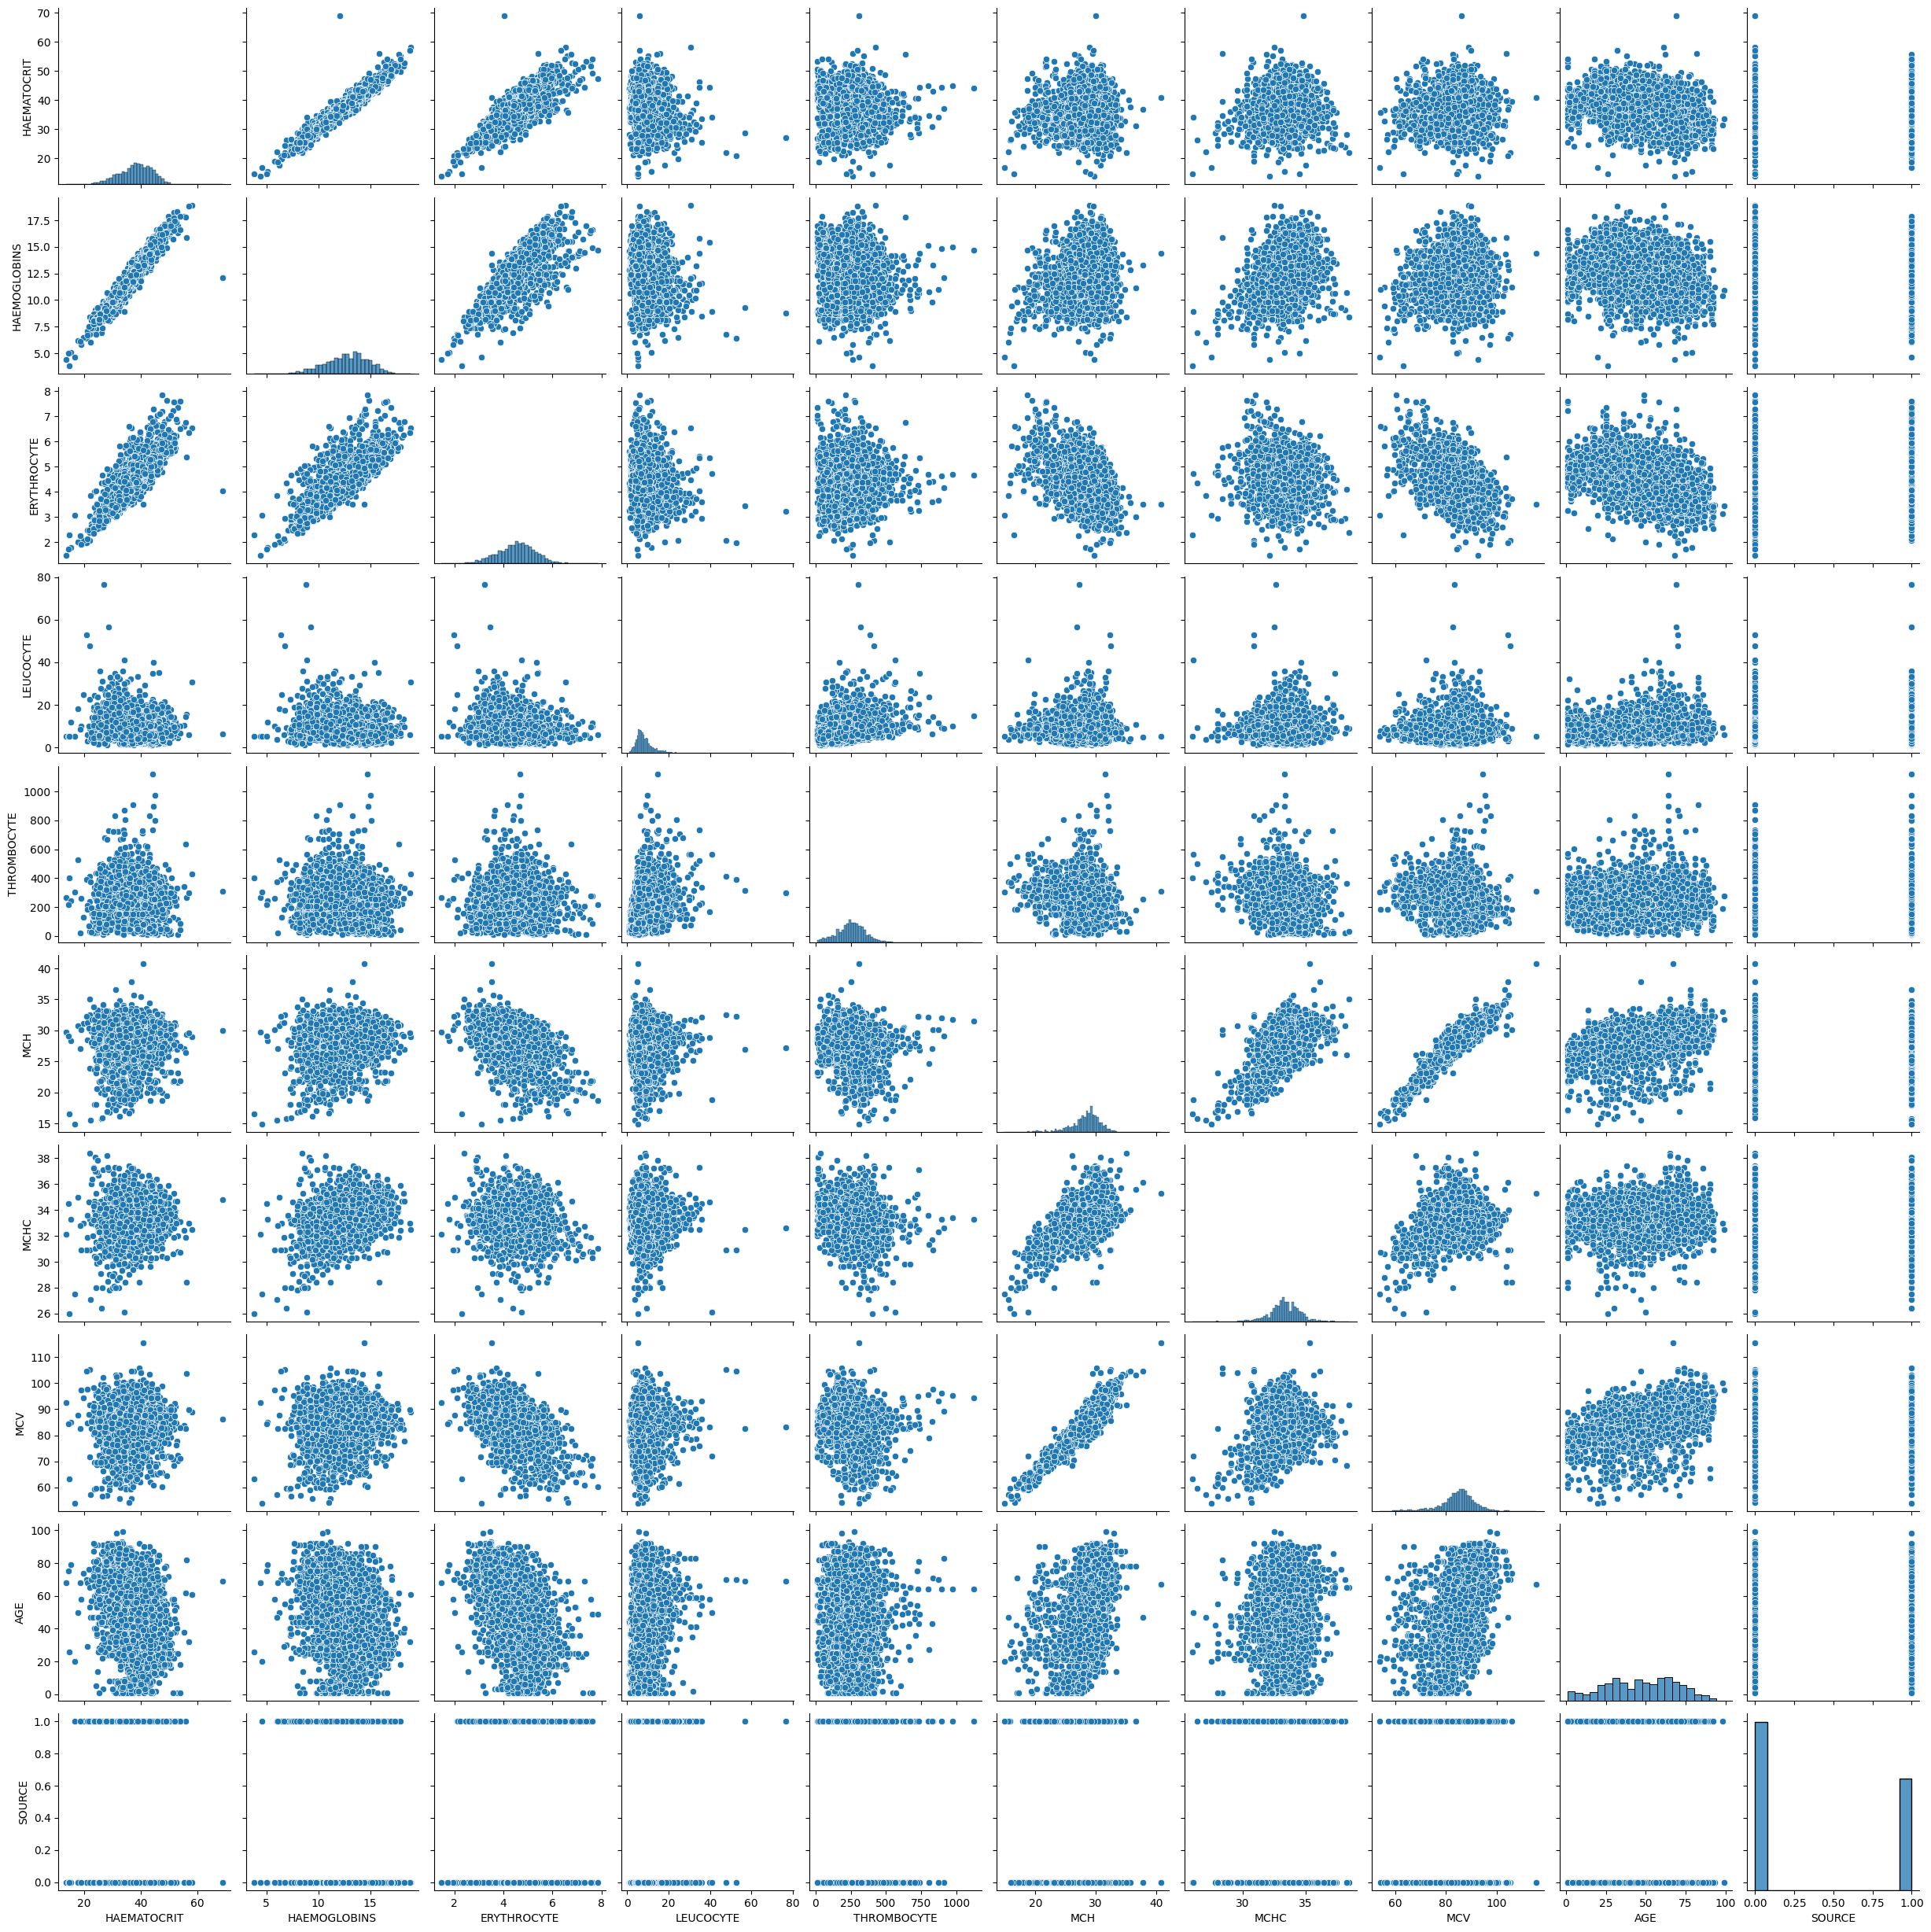

In [13]:
# Pairplot if the dataset data
sns.pairplot(data)
plt.show()

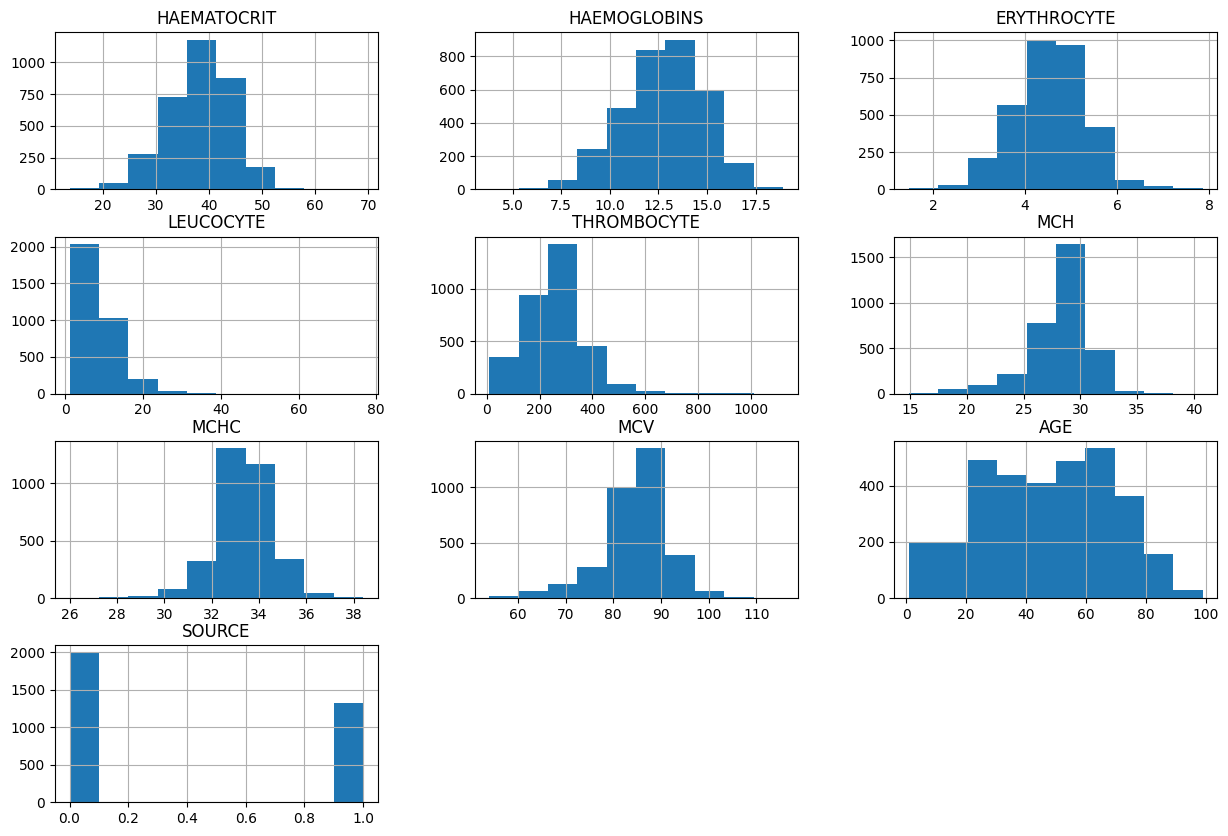

In [14]:
# Hist plot of the dataset df
data.hist(figsize=(15, 10))
plt.show()

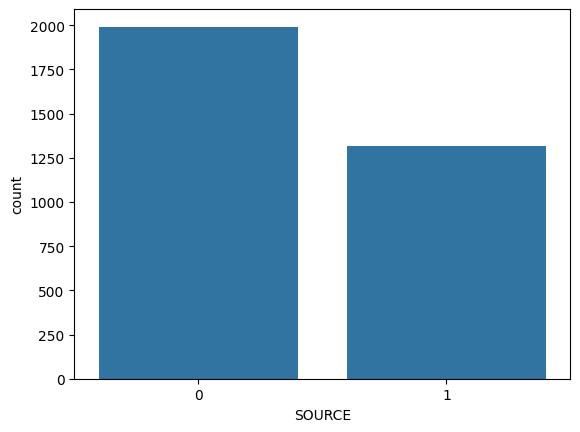

In [15]:
# Count plot of the SOURCE
sns.countplot(data=data, x='SOURCE')
plt.show()

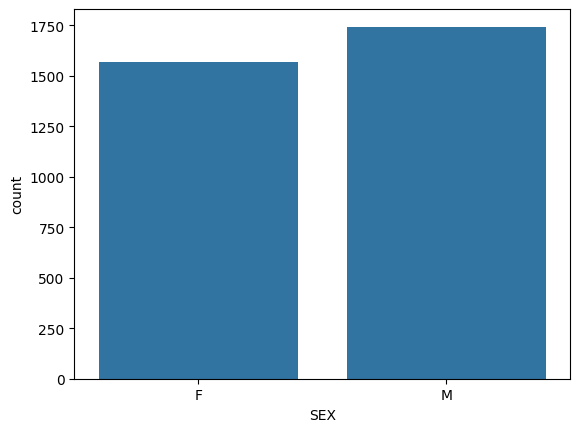

In [17]:
# Count plot of Male and Female
sns.countplot(data=data, x='SEX')
plt.show()

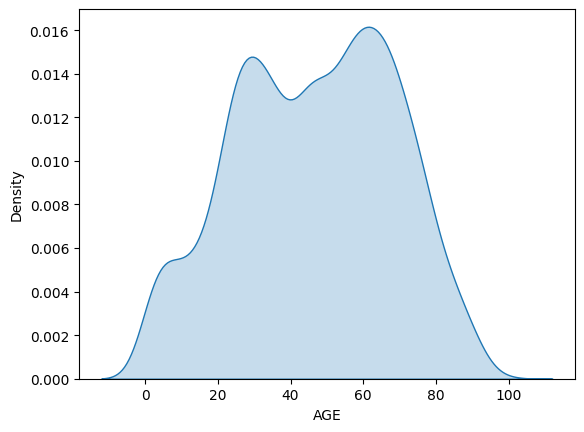

In [18]:
# Plot to see the Age distribution
sns.kdeplot(data=data, x='AGE', shade=True)
plt.show()

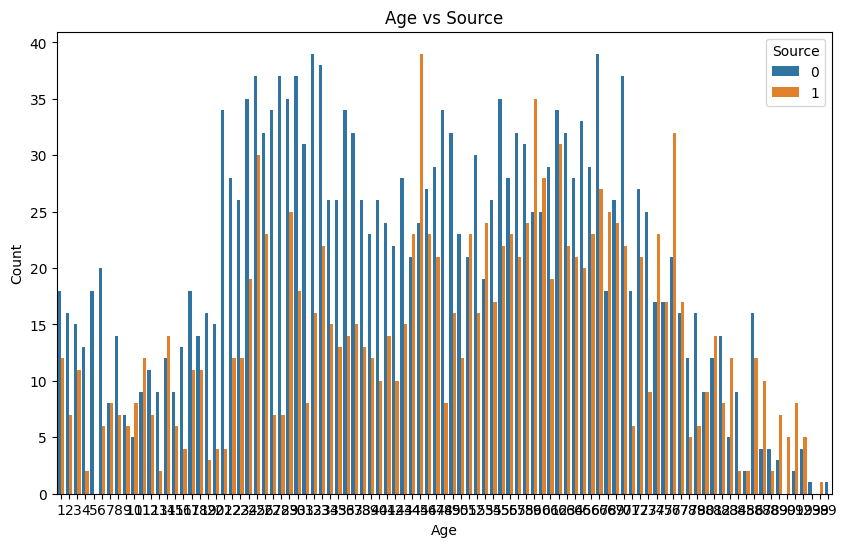

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AGE', hue='SOURCE', data=data)
plt.title('Age vs Source')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()

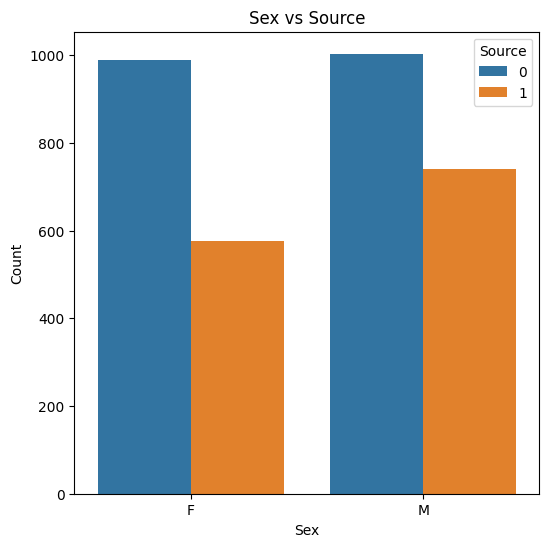

In [20]:
plt.figure(figsize=(6, 6))
sns.countplot(x='SEX', hue='SOURCE', data=data)
plt.title('Sex vs Source')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()

##Plotting the correlation matric to get the relationship between features

In [22]:
corr_mat = data.corr(numeric_only=True)

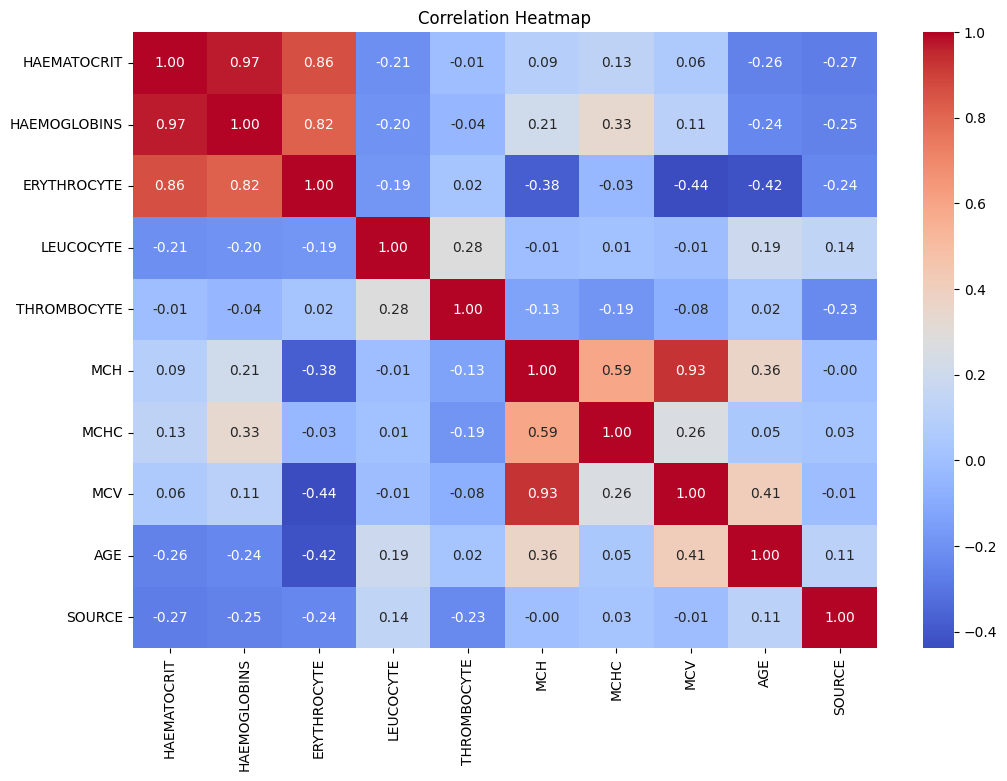

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

##***Plotting the Boxplot to detect the outliers***

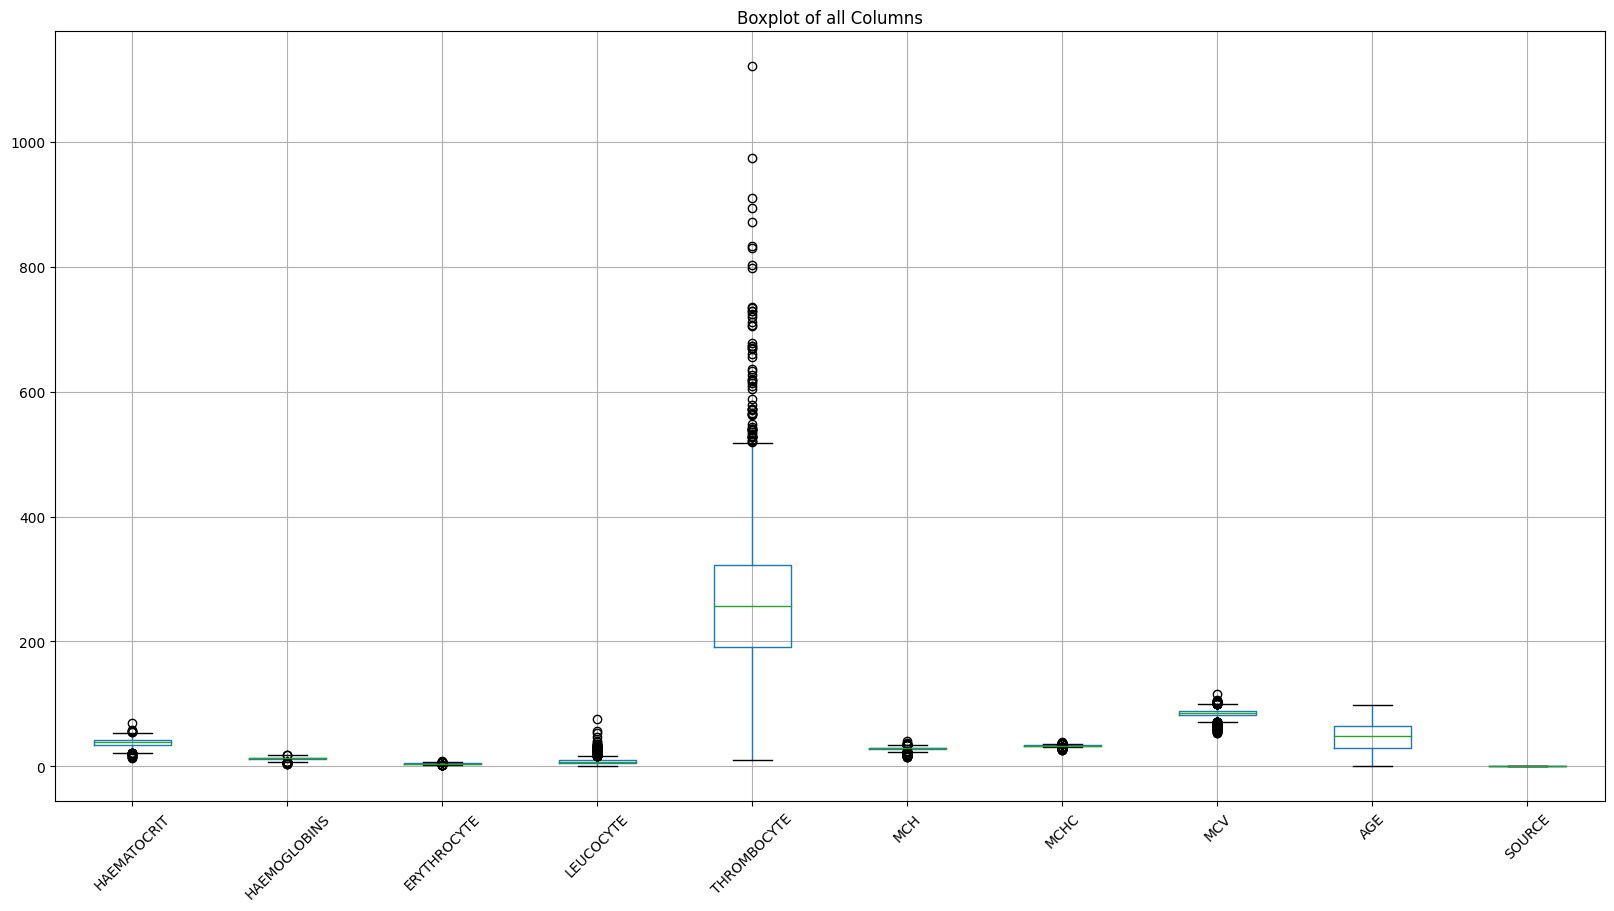

In [24]:
plt.figure(figsize=(20, 10))
data.boxplot()
plt.xticks(rotation=45)
plt.title('Boxplot of all Columns')
plt.show()

In [25]:
numeric_cols = data.select_dtypes(include=['number']).columns
numeric_df = data[numeric_cols]

##***Finding out the Outlier's***

In [26]:
z_scores = zscore(numeric_df)
outliers = (z_scores > 3) | (z_scores < -3)
outlier_indices = data.index[outliers.any(axis=1)]
outliers_df = data.loc[outlier_indices]

print(outliers_df)

      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
4            40.6          13.3         4.85       14.9          711  27.4   
14           35.9          10.4         5.45        8.0          500  19.1   
16           22.0           6.8         2.09       47.7          414  32.5   
18           35.1          10.4         5.20        7.1          254  20.0   
35           31.3          10.3         3.74       30.1          562  27.5   
...           ...           ...          ...        ...          ...   ...   
3248         44.1          14.7         4.67       14.8         1121  31.5   
3253         51.7          16.5         7.57        9.7          279  21.8   
3261         47.4          14.7         7.86        6.1          216  18.7   
3278         32.3          12.0         3.99       16.4          421  30.1   
3298         37.2          11.7         6.18       16.6          336  18.9   

      MCHC    MCV  AGE SEX  SOURCE  
4     32.8   83.7   36   M

In [27]:
num_outliers_df = outliers_df[numeric_cols]

# Iterate over each column in the outliers_df DataFrame
for column in num_outliers_df.columns:
    # Calculate the IQR for the column
    Q1 = num_outliers_df[column].quantile(0.25)
    Q3 = num_outliers_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Find the outliers using the IQR method
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = num_outliers_df[(num_outliers_df[column] < lower_bound) | (num_outliers_df[column] > upper_bound)]

    # Print the outliers for each column
    if not outliers.empty:
        print(f"Column: {column}")
        print(outliers)

Column: HAEMATOCRIT
      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
141          58.1          18.9         6.53       30.8          428  28.9   
467          13.7           4.4         1.48        5.3          263  29.7   
663          56.0          15.9         5.40       15.7          263  29.4   
871          53.0          16.3         7.54        4.3          112  21.6   
1487         53.2          17.0         7.35        6.1           12  23.1   
1998         54.0          16.6         7.61       10.0           88  21.8   
2057         57.0          18.8         6.35        5.9          299  29.6   
2108         55.8          17.8         6.75       14.5          637  26.4   
2197         14.5           5.0         1.72        5.0          217  29.1   
2361         14.6           3.8         2.31        5.2          403  16.5   
2822         52.5          17.3         6.90        8.0          211  25.1   
3171         69.0          12.1         4.04

##***Outlier Treatment***

In [28]:
def outlier_treatment(dataframe):

    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns

    aligned_dataframe = dataframe[numeric_columns].align(dataframe[numeric_columns], axis=1, copy=False)[0]

    Q1 = dataframe[numeric_columns].quantile(0.25)
    Q3 = dataframe[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((aligned_dataframe < (Q1 - 1.5 * IQR)) | (aligned_dataframe > (Q3 + 1.5 * IQR)))

    df_rem_out = dataframe[~outliers.any(axis=1)]
    return df_rem_out

dataset = outlier_treatment(data)

In [29]:
dataset.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,F,1
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,F,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,F,0
5,32.8,11.2,3.94,11.0,324,28.4,34.1,83.2,89,F,0
7,38.4,12.3,4.37,9.0,193,28.1,32.0,87.9,74,M,1


##***Converting the SEX column from Categorical to numerical***

In [30]:
sex_map = {'M': 0, 'F': 1}
dataset['SEX'] = dataset['SEX'].map(sex_map)

In [32]:
#check the male /female  in to categorical data to numerical data
dataset.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,1,1
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,1,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,1,0
5,32.8,11.2,3.94,11.0,324,28.4,34.1,83.2,89,1,0
7,38.4,12.3,4.37,9.0,193,28.1,32.0,87.9,74,0,1


##***Separating the Feature and Target variables***

In [33]:
X = dataset.drop('SOURCE', axis=1)
y = dataset['SOURCE']

##***Splitting the training and testing datasets using train_test_split***

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##***Training a Random Forest Classifier model***

In [35]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##***Predicting the target using only the test features***

In [37]:
y_pred = rf_clf.predict(X_test)

##***Evaluating the model on accuracy***

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7629233511586453


In [39]:
clf_report = classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       348
           1       0.74      0.57      0.65       213

    accuracy                           0.76       561
   macro avg       0.76      0.73      0.73       561
weighted avg       0.76      0.76      0.76       561



##***Creating a confusion matrix***

In [40]:
cm = confusion_matrix(y_test, y_pred)

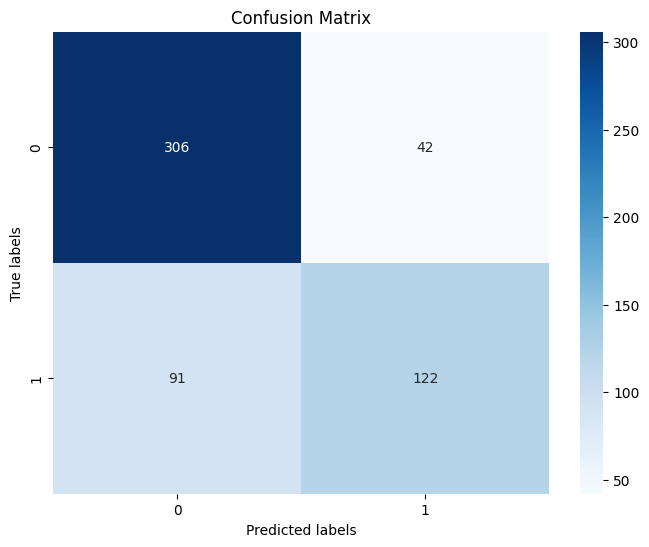

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##***features importances***

In [42]:
importances = rf_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
        Feature  Importance
4   THROMBOCYTE    0.221973
3     LEUCOCYTE    0.128340
0   HAEMATOCRIT    0.113343
2   ERYTHROCYTE    0.101623
8           AGE    0.095731
7           MCV    0.087376
1  HAEMOGLOBINS    0.082956
6          MCHC    0.078512
5           MCH    0.071471
9           SEX    0.018675


##bar for feature impotance

<Figure size 1000x800 with 0 Axes>

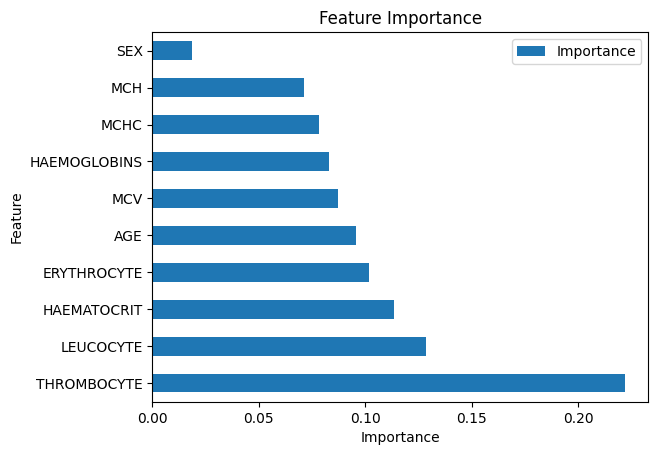

In [43]:
plt.figure(figsize=(10, 8))
feature_importance_df.plot(kind='barh', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##***Saving the model***

In [48]:
import os
import joblib

# Define the directory and file path
directory = '../models'
file_path = os.path.join(directory, 'model.joblib')

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Assuming rf_clf is your trained model
joblib.dump(rf_clf, file_path)
print(f"Model saved to {file_path}")

Model saved to ../models/model.joblib


##***Hyperparameter tuning***

In [49]:
param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [50]:
# Creating the GridSearchCV object
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='accuracy', verbose=2)

In [56]:
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate the model on the testing data
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy:  0.7611408199643493


##***Training a Logistic Regression model to compare***

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
acc_lr = accuracy_score(y_test, y_pred_lr)

In [59]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
acc_lr = accuracy_score(y_test, y_pred_lr)

In [60]:
# Print confusion matrix and accuracy score
print("Logistic Regression:")
print("Confusion Matrix:")
print(cm_lr)
print("Accuracy:", acc_lr)

Logistic Regression:
Confusion Matrix:
[[308  40]
 [101 112]]
Accuracy: 0.7486631016042781
